**Image Segmentation is a deep learning problem where we assign a class or label to each individual pixels. There are many different models for image segmentation. Here I am trying to build a model for wind turbine segmentation. For this particular task I used an encoder-decoder architecture using a pretrained MobileNetV2 architecture. The dataset used for training the model is given by SkySpecs. Few data augmentation techniques are used to train the model. The model is finally tested on a windturbine inspection dataset from DTU - Drone inspection images of wind 
turbine.**


                                                    

Packages used:
Tensorflow 2.x, OpenCV 3.x or 4.x, Numpy, Keras, Matplotlib, Scikit-Learn, Scikit_Image, TensorFlow-example. If you are using google colab to run the code, all package are preinstalled except TensorFlow-example .

---



By Sonu Dileep

In [ ]:
# Allow colab to access files in Drive. Comment it when running locally
from google.colab import drive
drive.mount('/content/drive')

# Install TensorFlow-example to load Pix2Pix
!pip install git+https://github.com/tensorflow/examples.git

Mounted at /content/drive
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-wwpkudqy
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-wwpkudqy
  Created wheel for tensorflow-examples: filename=tensorflow_examples-ff4ddd4609f76d8b7d085033a9b4cd9a3c6d26bd_-cp36-none-any.whl size=164220 sha256=1ae9af5387137486707cee2b0f52a31106d709aabfa9dc013330dd635de05ee8
  Stored in directory: /tmp/pip-ephem-wheel-cache-2b4yvmnq/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [ ]:
#Import required libraries
import tensorflow as tf
from keras.preprocessing import image 
from tensorflow_examples.models.pix2pix import pix2pix
from keras.callbacks import ModelCheckpoint


import os
import cv2
import copy
import numpy as np  
import matplotlib.pyplot as plt
from skimage.transform import rotate
from IPython.display import clear_output
from sklearn.model_selection import train_test_split


In [ ]:
# Load input image and mask path to a list
input_dir = "/content/drive/My Drive/SkySpecs/Images/" #input folder path
mask_dir = "/content/drive/My Drive/SkySpecs/Segmentation-Outputs/" # mask folder path
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(mask_dir, fname)
        for fname in os.listdir(mask_dir)
        if fname.endswith(".png") 
    ]
)

print("Number of samples:", len(input_img_paths))

Number of samples: 147


In [ ]:
#Load input and mask images to memory
x_input = [] 
x_mask = []
img_size = 320 # Specify input size of the deep learning model (for mobilenetV2 maximum size is 224)

#To get input Images
for i in range(0,len(input_img_paths)): 
	img_path = input_img_paths[i] 
	temp_img = cv2.imread(img_path)
	temp_img = cv2.resize(temp_img,(img_size,img_size))  
	x_input.append(temp_img) #Append each image to x_input list
 
# To get mask images 
for i in range(0,len(target_img_paths)): 
	img_path = target_img_paths[i] 
	temp_img = cv2.imread(img_path,0) 
	(thresh, temp_img) = cv2.threshold(temp_img, 127, 255, cv2.THRESH_BINARY) #Binary Conversion. 0's for background and 1's for mask
	temp_img = cv2.resize(temp_img,(img_size,img_size))
	x_mask.append(temp_img) #Append each mask to x_mask list

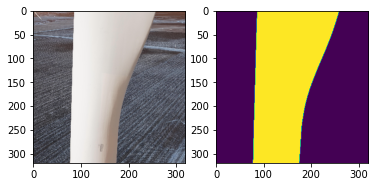

In [ ]:
# Check whether mask and input images are ordered correctly
i = 69
plt.subplot(1, 2, 1)
plt.imshow(x_input[i])
plt.subplot(1, 2, 2)
plt.imshow(x_mask[i])

In [ ]:
#Pre-processing - Image Normalization
x_input = np.asarray(x_input) #Convert to numpy array
x_mask = np.asarray(x_mask) #Convert to numpy array


x_input = x_input/255.0 #Normalize each image so that pixel values lie between 0 and 1
x_mask = x_mask/255 
x_mask = x_mask.astype(np.uint8) #Convert the mask image to uint8 so that the values are either 0 or 1

Keep 80% of the data for training and rest 20% for training

In [ ]:
# Split the dataset into training and testing
seed = 4
x_train, x_test, y_train, y_test = train_test_split(x_input, x_mask, test_size = 0.20, random_state=seed) # Adjust the test_size to change testing data size

**Data Augmentation**
The data augmentation techniques used here are Flipping and Rotation. The image is flipped both horizontally and vertically. The images are rotated by 30, 45, 60 and 90 degree. 

In [ ]:
#Data Augmentations - Flipping and Rotations
from skimage.transform import rotate
def img_flip(x_train,y_train): # Function to flip images vertically and horizontally
    X_trainv = np.flipud(x_train) #Vertical flip
    X_trainh = np.fliplr(x_train) #Horizontal flip
    X_train_total = np.concatenate([x_train, X_trainv, X_trainh])

    Y_trainv = np.flipud(y_train)
    Y_trainh = np.fliplr(y_train)
    Y_train_total = np.concatenate([y_train, Y_trainv, Y_trainh])
    return X_train_total, Y_train_total # Returns input and mask images flipped

def img_rotate(X_train,Y_train): # Function to rotate images by 30, 45, 60 and 90 degree
    temp_img = []
    temp_mask = []
    for i in range(len(X_train)):
      img = X_train[i]
      img_mask = Y_train[i]
      rotate30 = rotate(img, angle=30)
      rotate45 = rotate(img, angle=45)
      rotate60 = rotate(img, angle=60)
      rotate90 = rotate(img, angle=90)
    
      rotate30_mask = rotate(img_mask, angle=30)
      rotate45_mask = rotate(img_mask, angle=45)
      rotate60_mask = rotate(img_mask, angle=60)
      rotate90_mask = rotate(img_mask, angle=90)

      temp_img.extend([rotate30, rotate45, rotate60, rotate90])
      temp_mask.extend([rotate30_mask, rotate45_mask, rotate60_mask, rotate90_mask ])
    return temp_img, temp_mask # Return rotated input and mask image

m,n = img_rotate(x_train, y_train)
m1,n1 = img_flip(x_train, y_train)
print("Number of Flipped images + input images : ",len(m1))
print("Number of Rotated images : ",len(m))

Number of Flipped images + input images :  351
Number of Rotated images :  468


In [ ]:
#Convert to numpy array and concatenate flipped and rotated images
rotate_input = np.asarray(m)
rotate_mask = np.asarray(n)
flip_input = np.asarray(m1)
flip_mask = np.asarray(n1)
x_train = np.concatenate([rotate_input, flip_input])
y_train = np.concatenate([rotate_mask, flip_mask])
print("Total Size of Training set : ",x_train.shape[0])

Total Size of Training set :  819


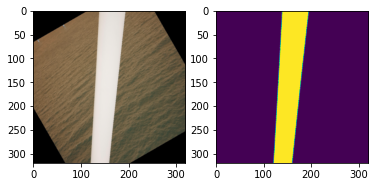

In [ ]:
# Check whether mask and input images are ordered correctly
i = 200
plt.subplot(1, 2, 1)
plt.imshow(x_train[i])
plt.subplot(1, 2, 2)
plt.imshow(y_train[i])
y_train = y_train.astype(np.uint8)

In [ ]:
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

In [ ]:
import tensorflow as tf
#import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K  

img_shape = (img_size,img_size,3)
inputs = layers.Input(shape=img_shape)
# 256

encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

center = conv_block(encoder4_pool, 1024)
# center

decoder4 = decoder_block(center, encoder4, 512)
# 16

decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block(decoder2, encoder1, 64)
# 128

decoder0 = decoder_block(decoder1, encoder0, 32)
# 256

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

In [ ]:
model = models.Model(inputs=[inputs], outputs=[outputs])

In [ ]:
def dice_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.math.sigmoid(y_pred)
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return 1 - numerator / denominator

In [ ]:
model.compile(optimizer='adam', loss=dice_loss, metrics=dice_loss)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 320, 320, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 320, 320, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 320, 320, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
# save_model_path = '/tmp/weights.hdf5'
# cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', mode='max', save_best_only=True)


In [ ]:
#Set the number of epochs and batch size 
EPOCHS = 200
BATCH_SIZE = 32
checkpointer = ModelCheckpoint('/content/drive/My Drive/SkySpecs/507_1.h5', monitor='dice_loss', verbose=1, save_best_only=True, mode='min')
model_history = model.fit(x_train,y_train, epochs=EPOCHS, batch_size = BATCH_SIZE, callbacks=[checkpointer],validation_data=(x_test,y_test))

Epoch 1/200
26/26 [==============================] - ETA: 0s - loss: 0.8075 - dice_loss: 0.8064
Epoch 00001: dice_loss improved from inf to 0.80636, saving model to /content/drive/My Drive/SkySpecs/507_1.h5
26/26 [==============================] - 23s 883ms/step - loss: 0.8075 - dice_loss: 0.8064 - val_loss: 0.6185 - val_dice_loss: 0.6185
Epoch 2/200
26/26 [==============================] - ETA: 0s - loss: 0.7980 - dice_loss: 0.7979
Epoch 00002: dice_loss improved from 0.80636 to 0.79795, saving model to /content/drive/My Drive/SkySpecs/507_1.h5
26/26 [==============================] - 17s 664ms/step - loss: 0.7980 - dice_loss: 0.7979 - val_loss: 0.6053 - val_dice_loss: 0.6053
Epoch 3/200
26/26 [==============================] - ETA: 0s - loss: 0.7950 - dice_loss: 0.7941
Epoch 00003: dice_loss improved from 0.79795 to 0.79410, saving model to /content/drive/My Drive/SkySpecs/507_1.h5
26/26 [==============================] - 17s 663ms/step - loss: 0.7950 - dice_loss: 0.7941 - val_loss: 

**Architecture**

For Segmentation, I used an Encoder-Decoder Architecture. Encoder-Decoder model tries to learn the semantic information from the image and has the advantage of giving better result in cases with few training samples. I used a MobileNetV2 trained on imagenet as an encoder. Encoder transforms the input image into a feature vector. MobileNetV2 is a mobile model for embedded devices and it trains fast and also the inference speed is faster compared to other models. The decoder is an upsample block implemented using pix2pix. Pix2Pix is an architecture used for training a Deep CNN which helps in image to image translations. Tensorflow-examples has an implementation of pix2pix which can be used for this task. The outputs from intermediate layers of Encoder are passed to the Decoder. The last layer of decoder outputs the segmentation mask. 

Note :  Encoders are not trained during the training.


In [ ]:
model.save('/content/drive/My Drive/SkySpecs/best_encdec.h5') # Save the model to drive/disk

**RESULTS**
The best performing model acheived an accuracy of 99.81% on the training set and 92.26% on the validation set.

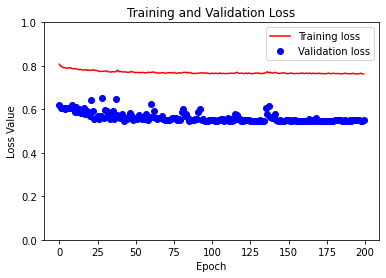

In [ ]:
#Plot the 'loss vs epoch' graph for training and validation
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(EPOCHS)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

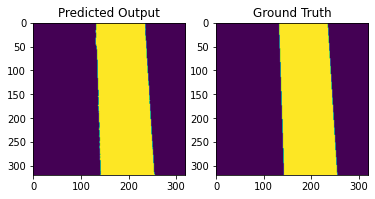

In [ ]:
#Result of the model from testing set
index = 1
val_preds = model.predict(x_test[index].reshape(1,img_size,img_size,3))
val_preds = val_preds.reshape(img_size,img_size)
for i in range(val_preds.shape[0]):
  for j in range(val_preds.shape[1]):
    if val_preds[i][j]>0.5:
      val_preds[i][j] = 255
    else:
      val_preds[i][j] = 0
plt.subplot(1, 2, 1)    
plt.title('Predicted Output')  
plt.imshow(val_preds)
plt.subplot(1, 2, 2)
plt.title('Ground Truth')
plt.imshow(y_test[index])

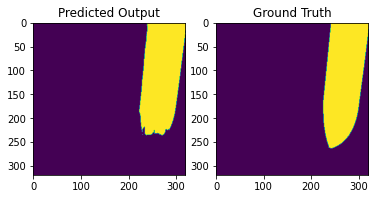

In [ ]:
#Result of the model from testing set 
index = 2
val_preds = model.predict(x_test[index].reshape(1,img_size,img_size,3))
val_preds = val_preds.reshape(img_size,img_size)
for i in range(val_preds.shape[0]):
  for j in range(val_preds.shape[1]):
    if val_preds[i][j]>0.1:
      val_preds[i][j] = 255
    else:
      val_preds[i][j] = 0
plt.subplot(1, 2, 1)    
plt.title('Predicted Output')  
plt.imshow(val_preds)
plt.subplot(1, 2, 2)
plt.title('Ground Truth')
plt.imshow(y_test[index])

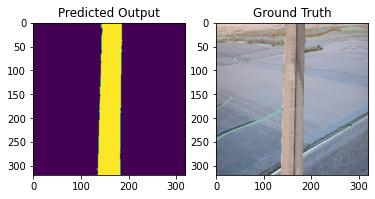

In [ ]:
#Result of the model from testing set 
index = 8
val_preds = model.predict(x_input[index].reshape(1,img_size,img_size,3))
val_preds = val_preds.reshape(img_size,img_size)
for i in range(val_preds.shape[0]):
  for j in range(val_preds.shape[1]):
    if val_preds[i][j]>0.5:
      val_preds[i][j] = 255
    else:
      val_preds[i][j] = 0
plt.subplot(1, 2, 1)    
plt.title('Predicted Output')  
plt.imshow(val_preds)
plt.subplot(1, 2, 2)
plt.title('Ground Truth')
plt.imshow(x_input[index])

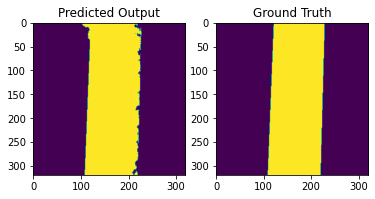

In [ ]:
#Result of the model from testing set
index = 14
val_preds = model.predict(x_test[index].reshape(1,img_size,img_size,3))
val_preds = val_preds.reshape(img_size,img_size)
for i in range(val_preds.shape[0]):
  for j in range(val_preds.shape[1]):
    if val_preds[i][j]>0.6:
      val_preds[i][j] = 255
    else:
      val_preds[i][j] = 0
plt.subplot(1, 2, 1)    
plt.title('Predicted Output')  
plt.imshow(val_preds)
plt.subplot(1, 2, 2)
plt.title('Ground Truth')
plt.imshow(y_test[index])

From the predictions on testset we can see that model started to identify the wind turbines but definitely need to improve a lot. Training the model using additional images could improve the results and also finding the right loss function will make a huge difference.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


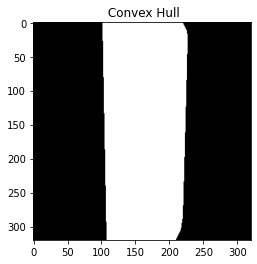

In [ ]:
#Find convex hull and draw convex hull with maximum area. This helps to remove the small noisy areas in the image
def find_hull(prediction):  # Input the segmented image from the model. Function outputs the convex hull with maximum area.
    prediction = prediction.astype(np.uint8) 
    contours, hierarchy = cv2.findContours(prediction, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # Find contours using opencv
    hull = []
    for i in range(len(contours)): # Find convex hull for each contour set
        hull.append(cv2.convexHull(contours[i], False))
    drawing = np.zeros((prediction.shape[0], prediction.shape[1], 3)) # Create an empty black image
    color = (255, 255, 255) # hull color
    c = max(hull, key = cv2.contourArea) # Find hull with maximum area
    m = []
    m.append(c)
    cv2.drawContours(drawing, m, -1, color,thickness = cv2.FILLED) 
    plt.title(' Convex Hull')
    plt.imshow(drawing)
    return drawing

hull = find_hull(val_preds)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


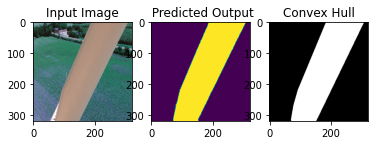

In [ ]:
#Testing the model on a different dataset - DTU - Drone inspection images of wind turbine from https://data.mendeley.com/datasets/hd96prn3nc/2
def test_model(img_path): #Input - test image path
    img = cv2.imread(img_path)
    img = cv2.resize(img,(img_size,img_size))
    plt.subplot(1, 3, 1)  
    plt.title('Input Image')    
    plt.imshow(img)
    img = img/255
    val_preds = model.predict(img.reshape(1,img_size,img_size,3))
    val_preds = val_preds.reshape(img_size,img_size)
    for i in range(val_preds.shape[0]):
      for j in range(val_preds.shape[1]):
        if val_preds[i][j]>0.1: # Keep only the pixels with value greater than 0.5
          val_preds[i][j] = 255
        else:
          val_preds[i][j] = 0
    plt.subplot(1, 3, 2)  
    plt.title(' Predicted Output')    
    plt.imshow(val_preds)
    pred = copy.deepcopy(val_preds)
    hull = []
    plt.subplot(1, 3, 3)
    hull = find_hull(pred)
    plt.title('Convex Hull')
    plt.imshow(hull)  
img_path = '/content/drive/My Drive/SkySpecs/DJI_0343.JPG'
test_model(img_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


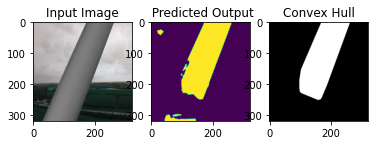

In [ ]:
img_path = '/content/drive/My Drive/SkySpecs/DJI_0616.JPG'
test_model(img_path)

**Future Work**
1. Using a large network like Mask_RCNN, DeepLab, FastFCN which supports larger images will improve the segmentation results, but requires higher computation memory. But these models will be hard to implement on mobile devices and drones.
2. Using different loss functions like Focal Loss, Dice Loss or IoU Loss could also improve the results further.
3. A depth estimation network can be used with the model to differentiate the wind turbine from the base of windmill.